## Reviews about mobile phones from amazon.com

In [156]:
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [20]:
items = pd.read_csv('20191226-items.csv')
items = items[['asin', 'brand', 'rating', 'totalReviews', 'price', 'originalPrice']]
items.rename(columns={'totalReviews': 'total_reviews', 'originalPrice': 'original_price'}, inplace=True)
print('items sample size: {}'.format(items.shape[0]))
items.head()

,asin,brand,rating,total_reviews,price,original_price
0,B0000SX2UC,NaN,3.0,14,0.00,0.0
1,B0009N5L7K,Motorola,3.0,7,49.95,0.0
2,B000SKTZ0S,Motorola,2.7,22,99.99,0.0
3,B001AO4OUC,Motorola,3.3,21,0.00,0.0
4,B001DCJAJG,Motorola,3.1,12,149.99,0.0


Some histograms (Maybe it's not bad to put some other comments here)

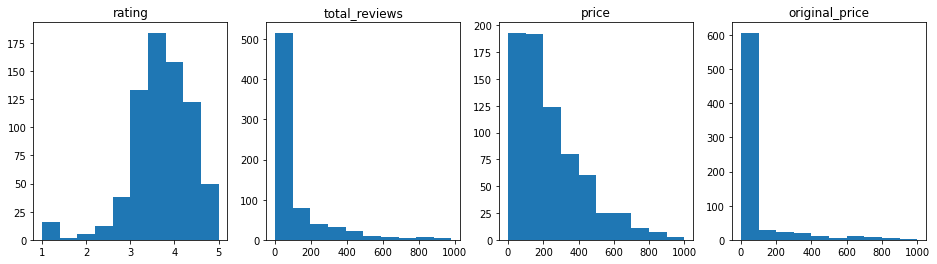

In [46]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, col in enumerate(items.columns[2:]):
    axs[i].hist(items[col])
    axs[i].set_title(col)

In [35]:
reviews = pd.read_csv('20191226-reviews.csv')
reviews.rename(columns={'helpfulVotes': 'helpful_votes'}, inplace=True)
print('reviews sample size: {}'.format(reviews.shape[0]))
reviews.head()

reviews sample size: 67986


,asin,name,rating,date,verified,title,body,helpful_votes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


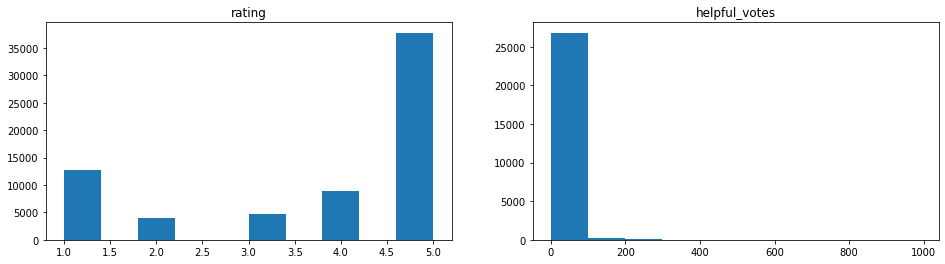

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
for i, col in enumerate(['rating', 'helpful_votes']):
    axs[i].hist(reviews[col])
    axs[i].set_title(col)

### User-based model

Selecting cumstomers, who has n (n = MIN_REVIEW_NUM) and more reviews

In [150]:
MIN_REVIEW_NUM = 3
pvt = reviews.groupby(['name']).count().reset_index() # 'count' is not nice, topic for codereview
csm_list = pvt[pvt.asin>=MIN_REVIEW_NUM].name.tolist()

reviews1 = reviews[reviews.name.isin(csm_list)]
print('sample length: {}'.format(reviews1.shape[0]))

sample length: 17925


Merging brand name instead off asin number, dropping rows with unplugged brand

In [151]:
reviews1 = reviews1[['asin', 'name', 'rating']].join(items[['asin', 'brand']].set_index('asin'), on='asin')
reviews1 = reviews1[reviews1.brand.isnull()==False]
reviews1.drop(['asin'], axis='columns', inplace=True)

print('sample length: {}'.format(reviews1.shape[0]))
reviews1.head()

sample length: 17879


,name,rating,brand
15,William B.,4,Motorola
21,Thomas,4,Motorola
23,Kristy,1,Motorola
27,Amazon Customer,1,Motorola
39,Linda,4,Motorola


Customers have reviews of phones with same brand. So it is needed to calculate mean value of rating in reviews of phones with same brands from one customer

In [152]:
reviews1 = reviews1.groupby(['name', 'brand']).mean().reset_index()
print('sample length: {}'.format(reviews1.shape[0]))
reviews1.head()

sample length: 4873


,name,brand,rating
0,:),Samsung,3.666667
1,A,Google,1.000000
2,A,HUAWEI,1.000000
3,A,Motorola,5.000000
4,A,Nokia,3.000000


Extracting a feature vector for each brand

In [153]:
# spand brand in columns, one for each brand
def func(x):
    x[x.brand] = 1
    return x

reviews1 = reviews1.apply(func, axis=1)
reviews1.drop(['brand'], axis='columns', inplace=True)
reviews1.head()

,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,name,rating
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,:),3.666667
1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,1.000000
2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,A,1.000000
3,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,A,5.000000
4,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,A,3.000000


In [154]:
cols = reviews1.columns.tolist()
for col in ['name', 'rating']:
    cols.remove(col)

reviews1[cols] = reviews1[cols].mul(reviews1['rating'], axis=0)
reviews1 = reviews1.fillna(value=0)
reviews1.head()

,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,name,rating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.666667,0.0,0.0,:),3.666667
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,A,1.000000
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,A,1.000000
3,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.000000,0.0,0.0,A,5.000000
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.000000,0.0,0.0,A,3.000000


In [157]:
reviews2 = reviews1[reviews1.columns[:-2]]

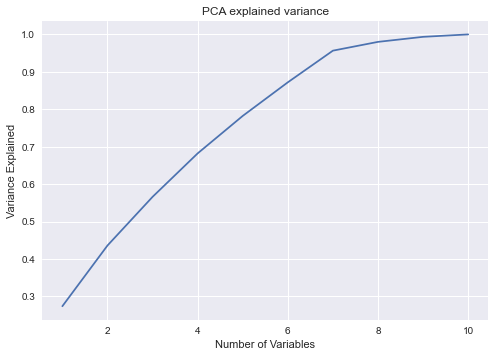

In [158]:
pca = PCA()
pca.fit(reviews2)
acc_var = np.cumsum(pca.explained_variance_ratio_) 

plt.style.use('seaborn')
plt.plot(range(1, len(acc_var)+1), acc_var)
plt.title('PCA explained variance')
plt.xlabel('Number of Variables')
_ = plt.ylabel('Variance Explained')

In [160]:
N_COMPONENTS = 7

pca.set_params(n_components=N_COMPONENTS)
pca.fit(reviews2)
reviews2_pca = pca.transform(reviews2)
reviews2_pos_pca = pd.DataFrame(reviews2_pca)
reviews2_pos_pca.head()

,0,1,2,3,4,5,6
0,2.722622,0.230065,0.062380,-0.058818,-0.058104,-0.016145,-0.012934
1,-0.750191,-0.410305,-0.214044,0.307826,0.806265,-0.575062,-0.124807
2,-0.732343,-0.383273,-0.187294,0.247831,0.439029,0.276871,0.939769
3,-2.090510,4.064035,0.460347,-0.383766,-0.359376,-0.101121,-0.082817
4,-0.992902,-0.784150,-0.661585,2.110492,-1.577708,-0.222303,-0.146046


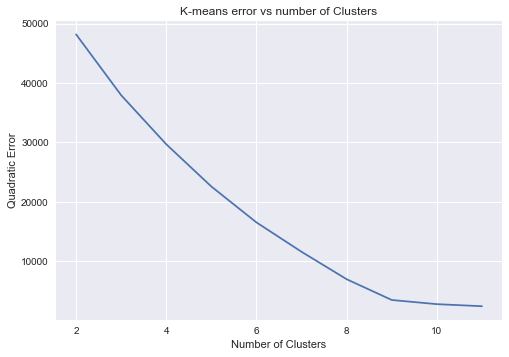

In [162]:
inertia = []
scores = []
for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(reviews2_pos_pca)
    inertia.append(kmeans.inertia_)
plt.plot(range(2, 12), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Quadratic Error')
_ = plt.title('K-means error vs number of Clusters')